<a href="https://colab.research.google.com/github/Niilop/Seq2Seq-text-autofill/blob/main/seq2seq_autofill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a auto fill project made seq2seq model with attention which is trained by email data. The model is trained with source and target pairs, where source is the start sequence of sentence and the target is the ending sequence of a sentence. For example a user might write "it is nice to" and the model would predict "meet you!". My future plan for this project is to develop runnable code on github which could be ran in a server and then used in a web UI.


Inspiration in time of need taken from:

https://dl.acm.org/doi/abs/10.1145/3292500.3330723

and

https://blog.jiayihu.net/gmail-smart-compose-in-keras-and-tensorflow-js/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data, datasets

import spacy
import numpy as np

import random
import math
import time

Random seed for deterministic results if needed

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We use Spacy tokenizer for this project

In [ ]:
!python3 -m spacy download en_core_web_sm
!python3 -m spacy download en_core_web_lg

2024-01-20 23:33:49.273406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-20 23:33:49.273463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-20 23:33:49.275090: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-20 23:33:51.463276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 48.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2024-01-20 23:34:08.856417: E external/local_xla/xla/stream

Downloading Amazon product dataset from Kaggle

In [ ]:
!pip install kaggle

Upload Kaggle API token from local files

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"niilopkknen","key":"a64107e80baeabe4f3bbb08d1cb21ac4"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download required data using Kaggle API

In [ ]:
'''
!mkdir amazon_data
!kaggle datasets download -d lokeshparab/amazon-products-dataset
!unzip /content/amazon-products-dataset.zip -d /content/amazon_data
'''

'\n!mkdir amazon_data\n!kaggle datasets download -d lokeshparab/amazon-products-dataset\n!unzip /content/amazon-products-dataset.zip -d /content/amazon_data\n'

In [ ]:
!mkdir email_data
!kaggle datasets download -d wcukierski/enron-email-dataset

100% 357M/358M [00:09<00:00, 45.1MB/s]
100% 358M/358M [00:09<00:00, 40.1MB/s]


In [ ]:
!unzip /content/enron-email-dataset.zip -d /content/email_data

Archive:  /content/enron-email-dataset.zip
  inflating: /content/email_data/emails.csv  


Earlier, I used amazon product data but it leads to weird results. Let's change the data to email data and try to train our model to autofill rest of the sentence.

In [ ]:
import os
current_directory = os.getcwd()
print(current_directory)

/content


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

emails_df = pd.read_csv('/content/email_data/emails.csv')
# Smaller size
# emails_df = emails_df[:1000]

In [ ]:
emails_df

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...
...,...,...
517396,zufferli-j/sent_items/95.,Message-ID: <26807948.1075842029936.JavaMail.e...
517397,zufferli-j/sent_items/96.,Message-ID: <25835861.1075842029959.JavaMail.e...
517398,zufferli-j/sent_items/97.,Message-ID: <28979867.1075842029988.JavaMail.e...
517399,zufferli-j/sent_items/98.,Message-ID: <22052556.1075842030013.JavaMail.e...


We only want name of the products

In [ ]:
emails_df['message']

0         Message-ID: <18782981.1075855378110.JavaMail.e...
1         Message-ID: <15464986.1075855378456.JavaMail.e...
2         Message-ID: <24216240.1075855687451.JavaMail.e...
3         Message-ID: <13505866.1075863688222.JavaMail.e...
4         Message-ID: <30922949.1075863688243.JavaMail.e...
                                ...                        
517396    Message-ID: <26807948.1075842029936.JavaMail.e...
517397    Message-ID: <25835861.1075842029959.JavaMail.e...
517398    Message-ID: <28979867.1075842029988.JavaMail.e...
517399    Message-ID: <22052556.1075842030013.JavaMail.e...
517400    Message-ID: <28618979.1075842030037.JavaMail.e...
Name: message, Length: 517401, dtype: object

In [ ]:
print(emails_df.iloc[9,1])

Message-ID: <30795301.1075855687494.JavaMail.evans@thyme>
Date: Mon, 16 Oct 2000 06:44:00 -0700 (PDT)
From: phillip.allen@enron.com
To: zimam@enron.com
Subject: FW: fixed forward or other Collar floor gas price terms
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: zimam@enron.com
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/16/2000 
01:42 PM ---------------------------


"Buckner, Buck" <buck.buckner@honeywell.com> on 10/12/2000 01:12:21 PM
To: "'Pallen@Enron.com'" <Pallen@Enron.com>
cc:  
Subject: FW: fixed forward or other Collar floor gas price terms


Phillip,

> As discussed  during our phone conversation, In a Parallon 75 microturbine
> power generation deal for a national accounts customer, I am developing a
> proposal to sell power to customer at fixed or collar/floor pr

In [ ]:
import email
# Function to extract email body from the raw email message
def extract_email_body(raw_email):
    msg = email.message_from_string(raw_email)
    return msg.get_payload()

# Apply the function to the 'email_message' column
emails_df['message'] = emails_df['message'].apply(extract_email_body)

In [ ]:
emails = emails_df['message']

Some emails are very long, so lets restrict them to 1000

In [ ]:
#filtered_emails = emails[~emails.str.contains('--------------------------', case=False) & (emails.str.len() <= 1000)]
array_emails = emails.values

lengths = np.vectorize(len)(array_emails)
index_of_longest = np.argmax(array_emails)

print(len(array_emails))
print(lengths)
print(index_of_longest)
print(len(array_emails[index_of_longest]))

mean_length = emails.str.len().mean()

# Example usage:
print("Mean length of emails:", mean_length)

517401
[  23  786   30 ...  326  170 3694]
12612
11628
Mean length of emails: 1845.3729563723302


In [ ]:
#products = electronics_df['name']
# Test with smaller batch
#filtered_emails = filtered_emails[:50000]

Lets filter all messages that contain "---------------------------" as they are very messy.

In [ ]:
spacy_en = spacy.load('en_core_web_sm')

Tokenizer function

In [ ]:
def tokeniser(text):
  return[tok.text for tok in spacy_en.tokenizer(str(text))]

In [ ]:
import re
import string
from nltk.corpus import stopwords

def normalize_df(data):
  # Lowercasing
  data = data.lower()
  # Removing special characters and punctuation
  data = re.sub(r'([.,!?]+)', r" \1 ", data)
  data = re.sub(r"[^a-zA-Z?.!,']+", " ", data)
  data = re.sub(r'[" "]+', " ", data)

  # Remove forwarded text
  data = data.split('forwarded by')[0]

  cleaned_data = data.strip()

  return cleaned_data

def normalize_input(text):

  #text = text.lower()
  #text = str(text)
  #normalized_text = re.sub(r'[^\w\s]', '', text)
  text = text.lower()
  text = re.sub(r'([.,!?]+)', r" \1 ", text)
  text = re.sub(r"[^a-zA-Z?.!,']+", " ", text)
  text = re.sub(r'[" "]+', " ", text)

  # Remove forwarded text
  text = text.split('forwarded by')[0]

  cleaned_text = text.strip()

  #cleaned_text = np.char.strip(np.char.replace(cleaned_text, '\n', ' '))
  #cleaned_text = np.char.strip(np.char.replace(cleaned_text, '\t', ' '))
  #normalized_text = np.char.replace(text, '[^\w\s]', '')

  return cleaned_text

In [ ]:
processed_data = list(map(normalize_df, emails))

Generate data set

We want to split all sentences to pairs in such way:

lets shoot for tuesday at 1145


'&lt;sos&gt; lets shoot &lt;eos&gt;' , '&lt;sos&gt; for tuesday at 1145 &lt;eos&gt;'

'&lt;sos&gt; lets shoot for &lt;eos&gt;' , '&lt;sos&gt; tuesday at 1145 &lt;eos&gt;'

In [ ]:
import spacy
nlp = spacy.load("en_core_web_lg")

max_words = 20

def replace_names_with_token(words):
  # Back to one sentence
  sentence = ' '.join(words)
  doc = nlp(sentence)

  words = []

  for token in doc:

    if token.ent_type_ == "PERSON":
      words.append("<name>")
    else:
      words.append(token.text)
  return words

def generate_dataset (data):
  pairs = []
  SRC = []
  TRG = []
  all_sentences = []

  for text in data:

    # Skip text that have over 100 words
    if len(text) > 100:
      continue

    # Let's split the emails into sentences
    sentences = text.split(' . ')


    for sentence in sentences:

      all_sentences.append(sentence)

      # Lets try to remove names from the emails
      sentence = re.sub("^\w+\s,\s", "", sentence)  # Remove from the start
      sentence = re.sub(r'\s*,\s*\w+\s*$', '', sentence)  # Remove from the end

      words = sentence.split(' ')

      # Remove sentences that are over 20 words and sentences that are less than 2 words.
      if len(words) > max_words or len(words) < 2:
          continue

      # For any names in the text, we can replace the names with <name> token using spacy
      # ADD THIS LATER TO SEE IF RESULTS ARE BETTER (VERY COMPUTATIONAL)!!
      #words = replace_names_with_token(words)

      for i in range(1, len(words) - 1):

          input_data = ' '.join(words[:i+1])
          output_data = ' '.join(words[i+1:])

          #SRC.append(input_data)
          #TRG.append(output_data)
          data = (input_data, output_data)
          pairs.append(data)

  return pairs, all_sentences

In [ ]:
test = [processed_data[5]]
print(test)

['greg , how about either next tuesday or thursday ? phillip']


In [ ]:
example = generate_dataset(test)
example[0]

[('how about', 'either next tuesday or thursday ? phillip'),
 ('how about either', 'next tuesday or thursday ? phillip'),
 ('how about either next', 'tuesday or thursday ? phillip'),
 ('how about either next tuesday', 'or thursday ? phillip'),
 ('how about either next tuesday or', 'thursday ? phillip'),
 ('how about either next tuesday or thursday', '? phillip'),
 ('how about either next tuesday or thursday ?', 'phillip')]

Generating pairs from the whole dataset

Parsing though the dataset and replacing names with <name> tag does take a lot of time so I might have to remove it.

runtime for generating datasets was 9 minutes.

In [ ]:
pairs, all_sentences = generate_dataset(processed_data)
print("AMOUNT OF PAIRS: ", len(pairs))
print("AMOUNT OF SENTENCES: ", len(all_sentences))

AMOUNT OF PAIRS:  509912
AMOUNT OF SENTENCES:  174377


In [ ]:
pairs[:25]

[('here is', 'our forecast'),
 ('here is our', 'forecast'),
 ('way to', 'go !!!'),
 ('way to go', '!!!'),
 ("let's shoot", 'for tuesday at .'),
 ("let's shoot for", 'tuesday at .'),
 ("let's shoot for tuesday", 'at .'),
 ("let's shoot for tuesday at", '.'),
 ('how about', 'either next tuesday or thursday ? phillip'),
 ('how about either', 'next tuesday or thursday ? phillip'),
 ('how about either next', 'tuesday or thursday ? phillip'),
 ('how about either next tuesday', 'or thursday ? phillip'),
 ('how about either next tuesday or', 'thursday ? phillip'),
 ('how about either next tuesday or thursday', '? phillip'),
 ('how about either next tuesday or thursday ?', 'phillip'),
 ('any morning', 'between and'),
 ('any morning between', 'and'),
 ('million is', 'fine phillip'),
 ('million is fine', 'phillip'),
 ('i think', 'fletch has a good cpa'),
 ('i think fletch', 'has a good cpa'),
 ('i think fletch has', 'a good cpa'),
 ('i think fletch has a', 'good cpa'),
 ('i think fletch has a goo

In [ ]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data):
  for sentence in data:
    yield tokeniser(sentence)

vocab = build_vocab_from_iterator(yield_tokens(all_sentences), specials=['<unk>', '<pad>', '<sos>', '<eos>', '<name>'], min_freq=10)
vocab.set_default_index(vocab["<unk>"])


In [ ]:
print("The length of the vocab is", len(vocab))
print(f"The index of '<unk>' is {vocab.get_stoi()['<unk>']}")
print(vocab.get_itos())

The length of the vocab is 4272
The index of '<unk>' is 0
['<unk>', '<pad>', '<sos>', '<eos>', '<name>', ',', 'the', '.', 'i', 'you', 'to', '?', 'is', 'this', 'for', 'please', 'thanks', 'a', 'fyi', 'on', '!', 'and', 'me', 'of', 'attached', 'in', "'s", 'have', 'it', 'are', 'we', 'here', 'your', 'see', 'with', 'my', 'at', 'do', 'be', 'will', 'enron', 'that', 'can', 'from', 'if', 'xls', 'call', 'what', 'vince', 'com', 'know', 'get', "n't", 'any', 'let', 'kay', 'am', 'as', 'http', 'not', 'up', 'out', 'jeff', 'mark', 'just', 'need', 'hourahead', '...', 'deal', 'file', 'fax', 'did', 'about', 'print', 'was', 'time', 'www', 'today', 'meeting', 'date', 'good', 'would', 'schedule', 'think', 'one', 'go', 'when', 'sent', 'like', 'send', 'regards', 'doc', 'our', 'start', 'phone', 'has', 'hpl', 'by', 'these', "'m", 'eb', 'should', 'how', 'or', 'there', 'all', 'carol', 'st', 'an', 'new', 'gas', 'per', 'so', 'pm', 'ben', 'm', 'download', 'going', 'd', 'email', 'want', 'e', 'find', 'no', "'ll", 'list',

Process he data. We turn all words in to tokens and change the data type to torch tensors for the PyTorch neural network.

In [ ]:
def data_process(pairs):
  data = []
  for (src, trg) in pairs:

    src_tensor = torch.tensor([vocab[token] for token in tokeniser(src)],
                            dtype=torch.long)

    trg_tensor = torch.tensor([vocab[token] for token in tokeniser(trg)],
                            dtype=torch.long)
    data.append((src_tensor, trg_tensor))
  return data

def input_process(input):

  input_tensor = torch.tensor([vocab[token] for token in tokeniser(input)],
                              dtype=torch.long)
  return input_tensor

full_data = data_process(pairs)
print(len(full_data))

509912


Tokenize the set of pairs to source and target data in a way that the neural network can use

In [ ]:
print(full_data[0])

for sentence in full_data[0]:
  words = [vocab.get_itos()[token] for token in sentence]
  print(words)

(tensor([31, 12]), tensor([  92, 1624]))
['here', 'is']
['our', 'forecast']


Data Loader

We generate batches for training using a DataLoader and add sos and eos tokens to the sentences.

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 512
#BATCH_SIZE = 256
PAD_IDX = vocab['<pad>']
SOS_IDX = vocab['<sos>']
EOS_IDX = vocab['<eos>']

def generate_batch(data_batch):
  src_batch, trg_batch = [], []

  for (src_item, trg_item) in data_batch:
    src_batch.append(torch.cat([torch.tensor([SOS_IDX]), src_item, torch.tensor([EOS_IDX])], dim=0))
    trg_batch.append(torch.cat([torch.tensor([SOS_IDX]), trg_item, torch.tensor([EOS_IDX])], dim=0))

  src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
  trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
  return src_batch, trg_batch

def generate_input_sequence(input_data):
  input_data = torch.cat([torch.tensor([SOS_IDX]), input_data, torch.tensor([EOS_IDX])]).to(device)
  return input_data

# Split the data to train, eval and test

size = len(full_data)

train_size = int(0.9 * size)
test_eval_size = (size - train_size) // 2

val_size = size - train_size - test_eval_size*2

print(size, train_size, test_eval_size)

train_data, test_data, val_data = random_split(full_data, [train_size+val_size, test_eval_size, test_eval_size])


train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True,
                        collate_fn=generate_batch)

test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                        shuffle=True,
                        collate_fn=generate_batch)

val_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True,
                        collate_fn=generate_batch)

509912 458920 25496


## Encoder

In [ ]:
import random
from typing import Tuple

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import tensor


class Encoder(nn.Module):
    def __init__(self,
                 input_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: float):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout

        # Embedding layer
        self.embedding = nn.Embedding(input_dim, emb_dim)

        # GRU
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)

        # Fully connected layer
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self,
                src: tensor) -> Tuple[tensor]:

        embedded = self.dropout(self.embedding(src))

        # Forward pass through GRU
        outputs, hidden = self.rnn(embedded)

        hidden_concat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        hidden = torch.tanh(self.fc(hidden_concat))

        return outputs, hidden

## Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        self.attn_in = (enc_hid_dim * 2) + dec_hid_dim

        self.attn = nn.Linear(self.attn_in, attn_dim)

    def forward(self,
                decoder_hidden: tensor,
                encoder_outputs: tensor) -> tensor:

        src_len = encoder_outputs.shape[0]

        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        a_score = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden,
            encoder_outputs),
            dim = 2)))

        attention = torch.sum(a_score, dim=2)

        # This gives us the attention over the source sentence
        return F.softmax(attention, dim=1)

## Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: int,
                 attention: nn.Module):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)

        self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout)


    def _weighted_encoder_rep(self,
                              decoder_hidden: tensor,
                              encoder_outputs: tensor) -> tensor:

        a = self.attention(decoder_hidden, encoder_outputs)


        a = a.unsqueeze(1)


        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted_encoder_rep = torch.bmm(a, encoder_outputs)

        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)

        return weighted_encoder_rep


    def forward(self,
                input: tensor,
                decoder_hidden: tensor,
                encoder_outputs: tensor) -> Tuple[tensor]:

        #input = [1, batch size]
        input = input.unsqueeze(0)


        #embedded = [1, batch size, emb dim]
        embedded = self.dropout(self.embedding(input))

        weighted_encoder_rep = self._weighted_encoder_rep(decoder_hidden,
                                                          encoder_outputs)

        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)

        output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)

        output = self.out(torch.cat((output,
                                     weighted_encoder_rep,
                                     embedded), dim = 1))

        return output, decoder_hidden.squeeze(0)



## Seq2Seq model

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 device: torch.device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self,
                src: tensor,
                trg: tensor,
                teacher_forcing_ratio: float = 0.4) -> tensor:

        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time

        batch_size = src.shape[1]
        max_len = trg.shape[0]

        trg_vocab_size = self.decoder.output_dim

        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)

        # first input to the decoder is the <sos> token
        output = trg[0,:]

        for t in range(1, max_len):
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(output, hidden, encoder_outputs)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from our predictions
            top1 = output.max(1)[1]

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            output = (trg[t] if teacher_force else top1)

        # Output shape = [batch size, 512, 4272]
        return outputs

    def predict(self, src: tensor) -> tensor:

        batch_size = src.shape[1]
        max_len = 20

        trg_vocab_size = self.decoder.output_dim

        outputs = torch.ones(max_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        output = src[0,:]

        pred = vocab.lookup_indices(['<sos>'])

        for t in range(1, max_len):
            output, hidden = self.decoder(output, hidden, encoder_outputs)

            predicted_token = output.argmax(1)
            pred.append(predicted_token)

            #outputs[t] = output
            output = output.argmax(1)  # Greedily select the token with the highest probability

            if predicted_token.item() == vocab['<eos>']:
              break


        return outputs

In [ ]:
INPUT_DIM = len(vocab)
OUTPUT_DIM = INPUT_DIM

# >  | Time: 2m 41s Train Loss: 4.933 | Train Perplexity: 138.839 |

ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ATTN_DIM = 32
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# >  | Time: 2m 30s Train Loss: 5.168 | Train Perplexity: 175.591 |
'''
ENC_EMB_DIM = 64
DEC_EMB_DIM = 64
ENC_HID_DIM = 128
DEC_HID_DIM = 128
ATTN_DIM = 32
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

TEACHER FORCING = 0.4
'''
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)


# Initialise weights
def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01) # Initialise weights with values drawn from the normal distribution
        else:
            nn.init.constant_(param.data, 0) # Initialiase biases to 0


print(model.apply(init_weights))

optimizer = optim.Adam(model.parameters())

# Determine number of paramters
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

# Loss function

PAD_IDX = vocab.get_stoi()['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4272, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=32, bias=True)
    )
    (embedding): Embedding(4272, 128)
    (rnn): GRU(640, 256)
    (out): Linear(in_features=896, out_features=4272, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
The model has 6,364,112 trainable parameters


## Train and evaluate functions

In [ ]:
import time
from tqdm import tqdm

def train(model: nn.Module,
          iterator: torch.utils.data.DataLoader,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss = 0

    iterator = tqdm(iterator, desc='Training', leave=False, ncols=100)

    for _, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        output = output[1:].view(-1, output.shape[-1])

        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        # Update the progress bar description with the current loss
        iterator.set_postfix(loss=epoch_loss / (_ + 1))

    return epoch_loss / len(iterator)


def evaluate(model: nn.Module,
             iterator: torch.utils.data.DataLoader,
             criterion: nn.Module):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for _, (src, trg) in enumerate(iterator):
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

##Training

In [ ]:
train_losses = []
valid_losses = []

Epoch: 01 | Time: 4m 1s
	Train Loss: 5.022 | Train Perplexity: 151.675 |
	 Val. Loss: 4.880 |   Val Perplexity: 131.652 |


Epoch: 02 | Time: 3m 57s
	Train Loss: 4.226 | Train Perplexity:  68.476 |
	 Val. Loss: 4.339 |   Val Perplexity:  76.660 |


Epoch: 03 | Time: 3m 57s
	Train Loss: 3.686 | Train Perplexity:  39.897 |
	 Val. Loss: 3.864 |   Val Perplexity:  47.642 |


Epoch: 04 | Time: 3m 57s
	Train Loss: 3.232 | Train Perplexity:  25.339 |
	 Val. Loss: 3.457 |   Val Perplexity:  31.729 |


Epoch: 05 | Time: 3m 58s
	Train Loss: 2.899 | Train Perplexity:  18.152 |
	 Val. Loss: 3.193 |   Val Perplexity:  24.373 |


Epoch: 06 | Time: 3m 58s
	Train Loss: 2.666 | Train Perplexity:  14.382 |
	 Val. Loss: 2.986 |   Val Perplexity:  19.814 |


Epoch: 07 | Time: 3m 58s
	Train Loss: 2.486 | Train Perplexity:  12.019 |
	 Val. Loss: 2.846 |   Val Perplexity:  17.211 |


Epoch: 08 | Time: 3m 58s
	Train Loss: 2.337 | Train Perplexity:  10.349 |
	 Val. Loss: 2.739 |   Val Perplexity:  15.470 |


Epoch: 09 | Time: 3m 57s
	Train Loss: 2.235 | Train Perplexity:   9.350 |
	 Val. Loss: 2.608 |   Val Perplexity:  13.578 |


Epoch: 10 | Time: 3m 56s
	Train Loss: 2.138 | Train Perplexity:   8.485 |
	 Val. Loss: 2.535 |   Val Perplexity:  12.619 |


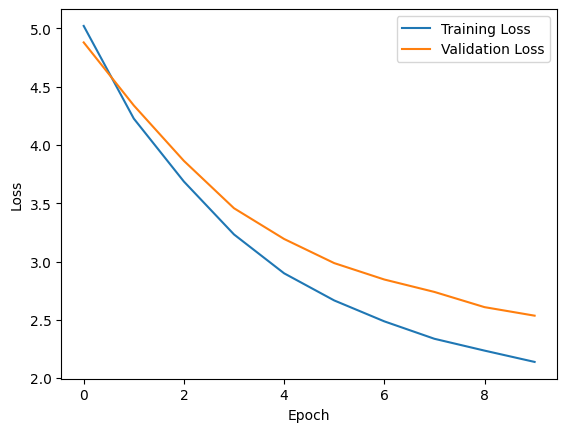

In [ ]:
import math
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_iter, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 's2s-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Perplexity: {math.exp(train_loss):7.3f} |')
    print(f'\t Val. Loss: {valid_loss:.3f} |   Val Perplexity: {math.exp(valid_loss):7.3f} |')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


# Plot the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading model weights and evaluating

In [ ]:
# Load the saved model weights
model.load_state_dict(torch.load('s2s-model.pt'))

test_loss = evaluate(model, test_iter, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test Perplexity: {math.exp(test_loss):7.3f} |')

In [ ]:
model.eval()

src = test_data[2][0].reshape(len(test_data[2][0]),1).to(device)
trg = test_data[2][1].reshape(len(test_data[2][1]),1).to(device)

src_words = [vocab.get_itos()[token] for token in src]
print(src_words)

trg_words = [vocab.get_itos()[token] for token in trg]
print(trg_words)

#print(src)
#print(trg)

In [ ]:
'''
def predict_sequence(input, model):
  model.eval()
  with torch.no_grad():
    for data in input:

      normalized_input = normalize_input(data)

      processed_input = input_process(normalized_input)

      input_seq = generate_input_sequence(processed_input)

      input_seq = input_seq.unsqueeze(1)


      output = model.predict(input_seq)

      output_idx = output[1:].squeeze(1).argmax(1)

      topk_values, topk_indices = output[1:].squeeze(1).topk(k=1, dim=1)
      # This top10 does NOT work with this, only the first one will make sense
      # The other ones are out of context as they are generated from the "main sequence"
      # To fix this, take top 10 predictions from first word and then run the network
      # for each word chosen aka 10 different times.
      print(f"PREDICTION FOR SEQUENCE: {data}")
      for row in topk_indices.t():
        #print(row)
        pred_words = [vocab.get_itos()[token] for token in row]
        words_str = data + ' ' + ' '.join(pred_words)
        print(words_str, "\n")
'''

In [ ]:
def predict_sequence(input, model):
  model.eval()
  with torch.no_grad():
    for data in input:

      normalized_input = normalize_input(data)
      processed_input = input_process(normalized_input)
      input_seq = generate_input_sequence(processed_input)
      input_seq = input_seq.unsqueeze(1)


      batch_size = 1
      max_len = 20

      trg_vocab_size = model.decoder.output_dim

      outputs = torch.ones(max_len, batch_size, trg_vocab_size).to(device)

      encoder_outputs, hidden = model.encoder(input_seq)

      output = src[0,:]

      pred = []

      for t in range(1, max_len):
          output, hidden = model.decoder(output, hidden, encoder_outputs)

          predicted_token = output.argmax(1)
          pred.append(predicted_token)

          #outputs[t] = output
          output = output.argmax(1)  # Greedily select the token with the highest probability

          if predicted_token.item() == vocab['<eos>']:
            break

      tokens = vocab.lookup_tokens(pred)
      return tokens



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('/content/s2s-model.pt'))

model.to(device)
predict_sequence(test, model)

In [ ]:
texts = [
    'here is',
    'have a',
    'please review',
    'please call me',
    'thanks for',
    'let me',
    'Let me know',
    'Let me know if you',
    'this sounds',
    'is this call going to',
    'can you get',
    'is it okay',
    'it should',
    'call if there\'s',
    'gave her a',
    'i will let',
    'i will be',
    'may i get a copy of all the',
    'how is our trade',
    'this looks like a',
    'i am fine with the changes',
    'please be sure this'
]

In [ ]:
for t in texts:

  prediction = ' '.join(predict_sequence([t], model))

  print(t, prediction)